## Setting a baseline for the competition: 

https://www.kaggle.com/competitions/playground-series-s3e1/data

#### 1. Setting up the configuration

In [56]:
import os

import numpy as np
import pandas as pd

# Preprocessing
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.model_selection import train_test_split

# Model Building
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import callbacks
from keras.callbacks import LearningRateScheduler
from tensorflow.keras.optimizers import SGD, Adam

from math import exp
# Data visualisation
import matplotlib.pyplot as plt

In [57]:
data_root = r'C:\kaggle\playground_series_s3e1\playground-series-s3e1'
train_filepath = os.path.join(data_root, 'train.csv')
test_filepath = os.path.join(data_root, 'test.csv')
sample_path = os.path.join(data_root, 'sample_submission.csv')

train_df = pd.read_csv(train_filepath, index_col='id')
test_df = pd.read_csv(test_filepath, index_col='id')
sample = pd.read_csv(sample_path)

train_df.head(5)

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
id,,,,,,,,,
0,2.3859,15.0,3.827160,1.112100,1280.0,2.486989,34.60,-120.12,0.980
1,3.7188,17.0,6.013373,1.054217,1504.0,3.813084,38.69,-121.22,0.946
2,4.7750,27.0,6.535604,1.103175,1061.0,2.464602,34.71,-120.45,1.576
3,2.4138,16.0,3.350203,0.965432,1255.0,2.089286,32.66,-117.09,1.336
4,3.7500,52.0,4.284404,1.069246,1793.0,1.604790,37.80,-122.41,4.500


Data Validation

In [58]:
# Check for null values
train_df.isna().sum()

MedInc         0
HouseAge       0
AveRooms       0
AveBedrms      0
Population     0
AveOccup       0
Latitude       0
Longitude      0
MedHouseVal    0
dtype: int64

In [59]:
# On initial glance these values all appear to be relatively normal and as expected
train_df.describe()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
count,37137.000000,37137.000000,37137.000000,37137.000000,37137.000000,37137.000000,37137.000000,37137.000000,37137.000000
mean,3.851029,26.057005,5.163124,1.062204,1660.778919,2.831243,35.570030,-119.554329,2.079751
std,1.803167,12.158221,1.206242,0.096490,1302.469608,2.702413,2.083179,1.974028,1.158571
min,0.499900,2.000000,0.851064,0.500000,3.000000,0.950000,32.550000,-124.350000,0.149990
25%,2.602300,17.000000,4.357522,1.020305,952.000000,2.394495,33.930000,-121.800000,1.208000
50%,3.515600,25.000000,5.068611,1.054545,1383.000000,2.744828,34.190000,-118.450000,1.808000
75%,4.699700,35.000000,5.858597,1.088825,1856.000000,3.125313,37.700000,-118.020000,2.660000
max,15.000100,52.000000,28.837607,5.873181,35682.000000,502.990610,41.950000,-114.550000,5.000010


In [60]:
skewed_cols = ['MedInc', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup']
for col in skewed_cols:
    train_df[col] = np.log(train_df[col])
    test_df[col] = np.log(test_df[col])

In [61]:
train_df.describe()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
count,37137.000000,37137.000000,37137.000000,37137.000000,37137.000000,37137.000000,37137.000000,37137.000000,37137.000000
mean,1.249758,26.057005,1.614762,0.057409,7.225711,1.007768,35.570030,-119.554329,2.079751
std,0.444341,12.158221,0.233688,0.072357,0.611200,0.235420,2.083179,1.974028,1.158571
min,-0.693347,2.000000,-0.161268,-0.693147,1.098612,-0.051293,32.550000,-124.350000,0.149990
25%,0.956396,17.000000,1.471904,0.020101,6.858565,0.873173,33.930000,-121.800000,1.208000
50%,1.257210,25.000000,1.623067,0.053110,7.232010,1.009718,34.190000,-118.450000,1.808000
75%,1.547499,35.000000,1.767910,0.085099,7.526179,1.139535,37.700000,-118.020000,2.660000
max,2.708057,52.000000,3.361680,1.770396,10.482402,6.220572,41.950000,-114.550000,5.000010


Feature scaling

An important step of building a successful Neural Network model is for it's features to be scaled. I have done this on all features within this dataset.

In [62]:
features = ['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude']
# Scale our features 
preprocessor = make_column_transformer((StandardScaler(), features))

In [63]:
# Split the target variable out
X_train = train_df.drop(labels=['MedHouseVal'], axis=1)
y_train = train_df["MedHouseVal"]

# set our test data 
X_test = test_df.copy()

In [64]:
# Transform the features
X_train[features] = preprocessor.fit_transform(X_train)
X_test[features] = preprocessor.transform(X_test)

In [65]:
# Split out our training data into a validation set
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2)
print(X_train.shape)
print(y_train.shape)
print(X_valid.shape)
print(y_valid.shape)

(29709, 8)
(29709,)
(7428, 8)
(7428,)


#### 2. Model Building

In [66]:
def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * exp(-0.1)

annealer = LearningRateScheduler(scheduler)


In [67]:
# Set the architecture for our model
model = keras.Sequential([
    layers.Dense(2048, activation='relu', input_shape=[X_train.shape[1]]),
    layers.BatchNormalization(),
    layers.Dense(1024, activation='relu', input_shape=[X_train.shape[1]]),
    layers.BatchNormalization(),
    layers.Dense(512, activation='relu', input_shape=[X_train.shape[1]]),
    layers.BatchNormalization(),
    layers.Dense(256, activation='relu', input_shape=[X_train.shape[1]]),
    layers.BatchNormalization(),
    layers.Dense(128, activation='relu', input_shape=[X_train.shape[1]]),
    layers.BatchNormalization(),
    layers.Dropout(0.4),
    layers.Dense(1),
])

In [68]:
# Compile our model setting an optimizer and loss function
model.compile(
    optimizer=Adam(learning_rate=1e-3),
    loss='mean_squared_error' # we can use mse as the loss function as our keras model doesn't have a root_mean_squared_error loss function 
)

In [69]:
early_stopping = callbacks.EarlyStopping(patience=15, min_delta=0.001, restore_best_weights=True)

In [70]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    batch_size=32,
    epochs=50, # Set this to a large number as early stopping will stop us once the min_delta isn't being reached
    # verbose=0, # suppress output as we'll plot the curves instead
    callbacks=[early_stopping, annealer]
)

Epoch 1/50
929/929 [==============================] - 20s 20ms/step - loss: 1.5478 - val_loss: 0.4558 - lr: 0.0010
Epoch 2/50
929/929 [==============================] - 17s 18ms/step - loss: 0.6392 - val_loss: 0.4368 - lr: 0.0010
Epoch 3/50
929/929 [==============================] - 18s 19ms/step - loss: 0.5464 - val_loss: 0.4144 - lr: 0.0010
Epoch 4/50
929/929 [==============================] - 17s 19ms/step - loss: 0.5081 - val_loss: 0.4300 - lr: 0.0010
Epoch 5/50
929/929 [==============================] - 17s 18ms/step - loss: 0.4958 - val_loss: 0.4171 - lr: 0.0010
Epoch 6/50
929/929 [==============================] - 17s 18ms/step - loss: 0.4901 - val_loss: 0.4177 - lr: 0.0010
Epoch 7/50
929/929 [==============================] - 16s 18ms/step - loss: 0.4857 - val_loss: 0.4214 - lr: 0.0010
Epoch 8/50
929/929 [==============================] - 17s 18ms/step - loss: 0.4841 - val_loss: 0.4197 - lr: 0.0010
Epoch 9/50
929/929 [==============================] - 18s 20ms/step - loss: 0.46

By plotting the history of each epoch we can see that we begin to overfit on the training set after around 60 epochs. This is the lowest point of validation loss and we have a gradual increase in validation_loss after that point.

Minimum Validation Loss: 0.3761


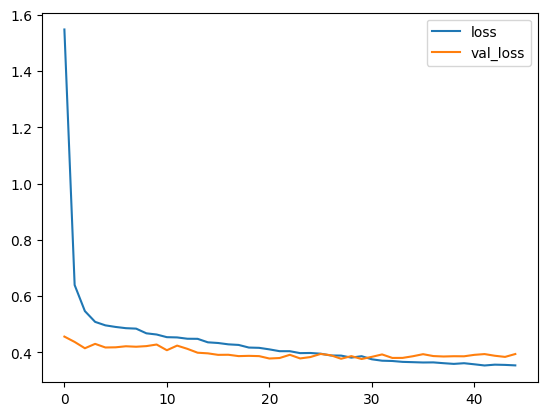

In [71]:
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot()
print("Minimum Validation Loss: {:0.4f}".format(history_df['val_loss'].min()))

In [72]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_13 (Dense)            (None, 2048)              18432     
                                                                 
 batch_normalization_7 (Batc  (None, 2048)             8192      
 hNormalization)                                                 
                                                                 
 dense_14 (Dense)            (None, 1024)              2098176   
                                                                 
 batch_normalization_8 (Batc  (None, 1024)             4096      
 hNormalization)                                                 
                                                                 
 dense_15 (Dense)            (None, 512)               524800    
                                                                 
 batch_normalization_9 (Batc  (None, 512)             

In [73]:
# Set our predictions and ravel them into a 1D array
preds = model.predict(X_test).ravel()
preds

774/774 [==============================] - 4s 5ms/step


array([0.7248474, 1.1366855, 3.6954782, ..., 1.1577764, 3.8448694,
       2.7609935], dtype=float32)

In [74]:
# Check the number of predictions matches the number of rows in the test dataset
len(preds) == len(X_test.index)

True

In [75]:
submission = pd.DataFrame({'id': test_df.index, 
                           'MedHouseVal': preds}).set_index('id')
submission.head()

,MedHouseVal
id,
37137,0.724847
37138,1.136685
37139,3.695478
37140,3.984373
37141,2.470031


In [76]:
submission.to_csv("submission_3.csv", index=True)